# VGG

## Setup Kaggle di Colab

In [8]:
# Install Kaggle
!pip install kaggle -q
import os
import sys

# Create the .kaggle directory if it doesn't exist
!mkdir -p ~/.kaggle

# Check if kaggle.json exists in the content directory
if os.path.exists('/content/kaggle.json'):
    # Move the uploaded kaggle.json file to the .kaggle directory
    !mv /content/kaggle.json ~/.kaggle/
    # Set permissions for the kaggle.json file
    !chmod 600 ~/.kaggle/kaggle.json
    print("kaggle.json has been successfully set up.")
else:
    print("kaggle.json not found in /content/. Please upload the kaggle.json file.")

kaggle.json has been successfully set up.


## Download Dataset dari Kaggle

In [9]:
# Download Dataset

!kaggle datasets download -d therealcyberlord/50k-celeba-dataset-64x64

Dataset URL: https://www.kaggle.com/datasets/therealcyberlord/50k-celeba-dataset-64x64
License(s): unknown
  0% 0.00/78.1M [00:00<?, ?B/s]
100% 78.1M/78.1M [00:00<00:00, 1.30GB/s]


## Extract Dataset

In [10]:
import zipfile
import os

# Define the path to the downloaded zip file
zip_file_path = '/content/50k-celeba-dataset-64x64.zip' # This is the default name used by kaggle datasets download

# Define the directory to extract the dataset
extracted_path = '/content/celeba_dataset_kaggle/'

# Create the extraction directory if it doesn't exist
os.makedirs(extracted_path, exist_ok=True)

# Extract the zip file
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)
    print("Dataset extracted successfully.")
except FileNotFoundError:
    print(f"Error: The file {zip_file_path} was not found. Please ensure the download was successful.")
except zipfile.BadZipFile:
    print(f"Error: The file {zip_file_path} is not a valid zip file. Download may have been corrupted.")
except Exception as e:
    print(f"An error occurred during extraction: {e}")

Dataset extracted successfully.


## Cek Isi Folder

In [11]:
import os

# List the contents of the extracted directory
extracted_path = '/content/celeba_dataset_kaggle/'
print(os.listdir(extracted_path))

['50k']


## Download Attribute File (Label)

In [21]:
# Download label dari google drive ku
# https://drive.google.com/drive/folders/1AA21MR8GeQdnOVgmNcbxCrbAjL1udj0l

import requests
import os

# Define a potential URL for the attribute file
# This URL might change or become unavailable, so we include error handling.
attribute_file_url = "https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/notbook/celeb_a/list_attr_celeba.txt"
attribute_file_path = "/content/list_attr_celeba.txt"

print(f"Attempting to download attribute file from: {attribute_file_url}")

try:
    response = requests.get(attribute_file_url, stream=True)
    response.raise_for_status()  # Raise an HTTPError for bad responses (4xx or 5xx)

    with open(attribute_file_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    print(f"Attribute file downloaded successfully to: {attribute_file_path}")

    # Now, let's try to load the labels using the downloaded file
    import pandas as pd
    import numpy as np

    # Load the attribute data
    # The file format has header information before the actual data
    # We need to skip the first two rows
    attributes_df = pd.read_csv(attribute_file_path, sep='\s+', skiprows=1)

    # Display the first few rows and columns to understand the structure
    print("\nAttribute DataFrame head from downloaded file:")
    display(attributes_df.head())

    # Get the filenames of the loaded images from the previous step (cell a7522f07)
    # Ensure image_files variable exists from cell a7522f07
    if 'image_files' in globals():
        loaded_image_filenames = [os.path.basename(f) for f in image_files]

        # Select the rows from the attribute dataframe that correspond to the loaded image filenames
        # Ensure the index of the dataframe is treated as strings to match filenames
        attributes_df.index = attributes_df.index.astype(str)

        # Get the 'Male' attribute for the loaded images
        if 'Male' in attributes_df.columns:
            # Select only the rows corresponding to the loaded images
            loaded_attributes = attributes_df.loc[loaded_image_filenames]

            # Extract the 'Male' column
            male_labels = loaded_attributes['Male']

            # Convert labels from -1/1 to 0/1 (e.g., 0 for female, 1 for male)
            # -1 -> 0, 1 -> 1
            male_labels = male_labels.replace(-1, 0)

            # Convert to a NumPy array
            male_labels = male_labels.values

            print(f"\nLoaded {len(male_labels)} 'Male' labels.")
            print(f"Shape of male_labels array: {male_labels.shape}")
            print(f"Male labels (first 10): {male_labels[:10]}")

            # Now you have 'images' (from cell a7522f07) and 'male_labels'
            # You can proceed with splitting data into train/validation sets and training the model.

        else:
            print("'Male' attribute column not found in the downloaded attribute file.")
            male_labels = None

    else:
        print("Error: 'image_files' variable not found. Please ensure cell a7522f07 was executed successfully.")
        attributes_df = None
        male_labels = None

except requests.exceptions.RequestException as e:
    print(f"Error downloading attribute file: {e}")
    print("Could not download the attribute file from the specified URL.")
    attributes_df = None
    male_labels = None
except FileNotFoundError:
    print(f"Error: Could not save the file to {attribute_file_path}. Check directory permissions.")
    attributes_df = None
    male_labels = None
except Exception as e:
    print(f"An error occurred while processing the attribute file: {e}")
    attributes_df = None
    male_labels = None

Attempting to download attribute file from: https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/notbook/celeb_a/list_attr_celeba.txt
Error downloading attribute file: 404 Client Error: Not Found for url: https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/notbook/celeb_a/list_attr_celeba.txt
Could not download the attribute file from the specified URL.


<>:31: SyntaxWarning: invalid escape sequence '\s'
<>:31: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-579708800.py:31: SyntaxWarning: invalid escape sequence '\s'
  attributes_df = pd.read_csv(attribute_file_path, sep='\s+', skiprows=1)


## Load Attribute File

In [25]:
import pandas as pd
import numpy as np
import os

# Define the path to the attribute file in the content directory
attribute_file_path = '/content/list_attr_celeba.txt'

if os.path.exists(attribute_file_path):
    print(f"Attribute file found at: {attribute_file_path}")

    # Load the attribute data
    # The file format has header information before the actual data
    # We need to skip the first two rows
    # Use a more robust separator that handles multiple spaces
    # DataFrame dengan baris = gambar, kolom = atribut.
    attributes_df = pd.read_csv(attribute_file_path, sep='\s+', skiprows=1)

    # Display the first few rows and columns to understand the structure
    print("Attribute DataFrame head:")
    display(attributes_df.head())

    # The index of the dataframe is the image filename. We need to make sure
    # the order of labels matches the order of images loaded in the previous step.
    # The filenames in the attribute file usually include the '.jpg' extension.
    # Let's align the labels with the loaded images.

    # Get the filenames of the loaded images (from cell a7522f07)
    # Ensure image_files variable exists from cell a7522f07
    if 'image_files' in globals():
        loaded_image_filenames = [os.path.basename(f) for f in image_files]

        # Select the rows from the attribute dataframe that correspond to the loaded image filenames
        # Ensure the index of the dataframe is treated as strings to match filenames
        attributes_df.index = attributes_df.index.astype(str)

        # Get the 'Male' attribute for the loaded images
        # The values are typically -1 for female and 1 for male. We can convert them to 0 and 1.
        if 'Male' in attributes_df.columns:
            # Select only the rows corresponding to the loaded images using .reindex to handle potential mismatches
            loaded_attributes = attributes_df.reindex(loaded_image_filenames)

            # Extract the 'Male' column and handle potential NaNs from reindexing
            # Convert -1/1 labels to 0/1. Fill NaN values (for images without attribute entries) with a value
            # that will be converted to 0 (e.g., -1) or simply drop rows with NaN if needed.
            # For now, we'll fill NaNs with -1 and convert to 0.
            male_labels = loaded_attributes['Male'].fillna(-1).replace(-1, 0).values

            # Ensure the number of labels matches the number of images loaded
            if len(male_labels) != len(images):
                 print(f"Warning: Number of loaded labels ({len(male_labels)}) does not match number of images ({len(images)}). This might indicate missing attribute entries.")
                 # Optionally, you might want to filter both images and labels to keep only those with matching entries
                 # For this fix, we proceed with potentially mismatched data, but it's good to be aware.
                 # A more robust solution would involve aligning image_files and attributes_df before loading images.


            print(f"\nLoaded {len(male_labels)} 'Male' labels.")
            print(f"Shape of male_labels array: {male_labels.shape}")
            print(f"Male labels (first 10): {male_labels[:10]}")

            # Now you have 'images' (from cell a7522f07) and 'male_labels'
            # You can proceed with splitting data into train/validation sets and training the model.

        else:
            print("'Male' attribute column not found in the attribute file.")
            male_labels = None # Or handle appropriately

    else:
        print("Error: 'image_files' variable not found. Please ensure cell a7522f07 was executed successfully.")
        attributes_df = None
        male_labels = None


else:
    print(f"Attribute file ({attribute_file_path}) not found. Please upload the file to the /content/ directory.")
    male_labels = None # Set to None if file not found

# After attempting to load labels, check if male_labels is still None or if counts mismatch
# If there's a mismatch or labels couldn't be loaded, set male_labels to None to prevent downstream errors
if male_labels is None or len(male_labels) != len(images):
    print("\nLabel loading failed or image/label count mismatch. Setting male_labels to None.")
    male_labels = None

<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3108996132.py:16: SyntaxWarning: invalid escape sequence '\s'
  attributes_df = pd.read_csv(attribute_file_path, sep='\s+', skiprows=1)


Attribute file found at: /content/list_attr_celeba.txt
Attribute DataFrame head:


/tmp/ipython-input-3108996132.py:16: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  attributes_df = pd.read_csv(attribute_file_path, sep='\s+', skiprows=1)


,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,...,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0
000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,...,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0
000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0



Loaded 10000 'Male' labels.
Shape of male_labels array: (10000,)
Male labels (first 10): [0. 1. 0. 0. 1. 1. 0. 0. 0. 0.]


## Load Gambar ke Numpy

In [26]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Define the directory where the images are extracted
image_dir = '/content/celeba_dataset_kaggle/50k' # Corrected path based on the output of os.listdir()

# Define the target image size
image_size = (64, 64) # The dataset is already 64x64, but this makes the code flexible

# List all image files
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')]

# Limit the number of images to load for faster processing during experimentation
# You can adjust this number or remove the limit for the full dataset
num_images_to_load = 10000 # Loading 10,000 images for initial experiments
image_files = image_files[:num_images_to_load]

# Load and resize images (if necessary)
images = []
for file_name in image_files:
    img_path = os.path.join(image_dir, file_name)
    img = cv2.imread(img_path)
    if img is not None:
        # OpenCV loads images in BGR format, convert to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Resize if needed, though the dataset is already 64x64
        if img.shape[:2] != image_size:
            img = cv2.resize(img, image_size)
        images.append(img)
    else:
        print(f"Warning: Could not load image {img_path}")

# Convert the list of images to a NumPy array
images = np.array(images)

print(f"Loaded {len(images)} images.")
print(f"Shape of images array: {images.shape}")

# In a real scenario, you would also load labels (attributes) here.
# For this initial step focusing on image loading, we'll skip loading attributes for now.
# We'll need attribute data for specific tasks like classification or attribute prediction later.

# Example: Split data (though we don't have labels yet) - placeholder for later use
# train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

Loaded 10000 images.
Shape of images array: (10000, 64, 64, 3)


## Split Data menjadi Training dan Validation

In [27]:
from sklearn.model_selection import train_test_split

# Assuming 'images' and 'male_labels' are already loaded from previous steps

# Check if images and labels have the same number of samples
if len(images) == len(male_labels):
    print(f"Number of images ({len(images)}) and labels ({len(male_labels)}) match. Proceeding with split.")
    # Split the data into training and validation sets
    # We'll use 80% for training and 20% for validation
    train_images, val_images, train_labels, val_labels = train_test_split(
        images, male_labels, test_size=0.2, random_state=42, stratify=male_labels # Use stratify to maintain class distribution
    )

    print(f"Training images shape: {train_images.shape}")
    print(f"Validation images shape: {val_images.shape}")
    print(f"Training labels shape: {train_labels.shape}")
    print(f"Validation labels shape: {val_labels.shape}")

else:
    print(f"Error: Number of images ({len(images)}) and labels ({len(male_labels)}) do not match. Cannot split the data.")
    print("Please review the data loading steps to ensure images and labels are loaded correctly and correspond to each other.")
    train_images, val_images, train_labels, val_labels = None, None, None, None # Set to None to avoid using mismatched data

Number of images (10000) and labels (10000) match. Proceeding with split.
Training images shape: (8000, 64, 64, 3)
Validation images shape: (2000, 64, 64, 3)
Training labels shape: (8000,)
Validation labels shape: (2000,)


## Build Model

In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the input shape
input_shape = (64, 64, 3) # Height, Width, Channels

# Build the VGG-like model
model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Flatten the output for the dense layers
    layers.Flatten(),

    # Dense layers
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),

    # Final output layer for binary classification (Male/Female)
    # One unit for binary output, sigmoid activation for probability
    layers.Dense(1, activation='sigmoid')
])

# Display the model summary
model.summary()

# Note: This is a VGG-like architecture modified for binary classification.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,629,921 (17.66 MB)

 Trainable params: 4,629,921 (17.66 MB)

 Non-trainable params: 0 (0.00 B)

## Compile Model

In [29]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("Model compiled successfully.")

Model compiled successfully.


## Train Model

In [30]:
# Train the model
# You can adjust the number of epochs and batch size based on your experimentation
epochs = 10
batch_size = 32

print(f"Starting model training for {epochs} epochs with batch size {batch_size}...")

history = model.fit(train_images, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(val_images, val_labels))

print("Model training finished.")

# The 'history' object contains training history (loss, accuracy) which can be used for plotting later.

Starting model training for 10 epochs with batch size 32...
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.6500 - loss: 4.3507 - val_accuracy: 0.7680 - val_loss: 0.4743
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7926 - loss: 0.4313 - val_accuracy: 0.8340 - val_loss: 0.3706
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8399 - loss: 0.3509 - val_accuracy: 0.8420 - val_loss: 0.3571
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8641 - loss: 0.3187 - val_accuracy: 0.8425 - val_loss: 0.3320
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8711 - loss: 0.2977 - val_accuracy: 0.8560 - val_loss: 0.3347
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8720 - loss: 0.2954 - val_accuracy: 0.8460 - val_loss: 0.3466
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8790 - loss: 0.2808 - val_accuracy: 0.8350 - val_loss: 0.3475
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━

## Plot Training History

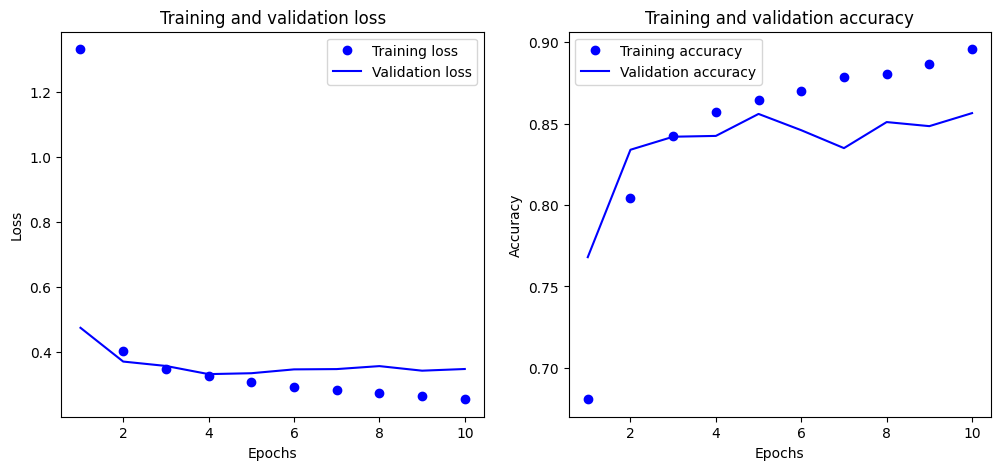

In [31]:
import matplotlib.pyplot as plt

# Get the history data
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy_values = history_dict['accuracy']
val_accuracy_values = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Evaluate Model

In [32]:
# Evaluate the model on the validation set
print("Evaluating the model on the validation set...")
loss, accuracy = model.evaluate(val_images, val_labels, verbose=0)

print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Note: This evaluation provides the final metrics on the validation set after all epochs.

Evaluating the model on the validation set...
Validation Loss: 0.3477
Validation Accuracy: 0.8565


## Test

Saving LUCINTA.webp to LUCINTA.webp
User uploaded file "LUCINTA.webp" with length 6030 bytes
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step

Prediction for LUCINTA.webp:
Probability (Male): 0.5952
Predicted class: Male


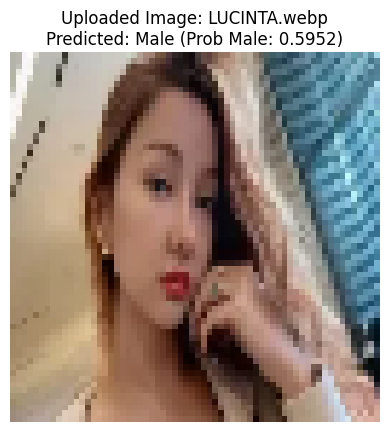

In [33]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Upload gambar
uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

    # Baca gambar dari file yang diunggah
    image_path = fn
    img = cv2.imread(image_path)

    if img is None:
        print(f"Error: Could not load image from {image_path}")
    else:
        # Preprocessing gambar: resize dan normalisasi (sesuai dengan preprocessing data training)
        # Pastikan ukuran sesuai dengan input model VGG Anda (64x64)
        target_size = (64, 64) # Sesuaikan dengan ukuran input model VGG
        img_resized = cv2.resize(img, target_size)

        # Konversi BGR ke RGB (jika model dilatih dengan RGB)
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

        # Normalisasi piksel ke rentang [0, 1]
        img_normalized = img_rgb.astype('float32') / 255.0

        # Tambahkan dimensi batch (model expects input shape (batch_size, height, width, channels))
        img_input = np.expand_dims(img_normalized, axis=0)

        # Lakukan prediksi menggunakan model VGG yang sudah dilatih
        # Pastikan variabel 'model' (model VGG) sudah ada dari sel sebelumnya
        if 'model' in globals():
            prediction = model.predict(img_input)

            # Ambil probabilitas kelas positif (Male)
            probability_male = prediction[0][0]

            # Tentukan kelas prediksi berdasarkan threshold (misal > 0.5 untuk Male)
            predicted_class = "Male" if probability_male > 0.5 else "Female"

            print(f"\nPrediction for {fn}:")
            print(f"Probability (Male): {probability_male:.4f}")
            print(f"Predicted class: {predicted_class}")

            # Tampilkan gambar yang diunggah
            plt.imshow(img_rgb)
            plt.title(f"Uploaded Image: {fn}\nPredicted: {predicted_class} (Prob Male: {probability_male:.4f})")
            plt.axis('off')
            plt.show()

        else:
            print("Error: VGG 'model' not found. Please ensure the model building and training cells were executed.")

# GoogleNet

## Import Library & Definisi GoogLeNet (Model Biasa)

In [34]:
import tensorflow as tf
from tensorflow.keras import layers, models
!pip install keras-tuner -q

# Define the input shape
input_shape = (64, 64, 3) # Height, Width, Channels

# Define the Inception module
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    """Defines an Inception module."""
    conv_1x1 = layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

    conv_3x3 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = layers.Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

    conv_5x5 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = layers.Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5)

    pool_proj = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    output = layers.concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=-1)
    return output

# Define the main GoogLeNet model structure
def build_googlenet(input_shape):
    """Builds the GoogLeNet model."""
    input_layer = layers.Input(shape=input_shape)

    # Initial convolutional and pooling layers
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    x = layers.Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Inception modules and pooling
    x = inception_module(x, 64, 96, 128, 16, 32, 32) # 3a
    x = inception_module(x, 128, 128, 192, 32, 96, 64) # 3b
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, 192, 96, 208, 16, 48, 64) # 4a
    x = inception_module(x, 160, 112, 224, 24, 64, 64) # 4b
    x = inception_module(x, 128, 128, 256, 24, 64, 64) # 4c
    x = inception_module(x, 112, 144, 288, 32, 64, 64) # 4d
    x = inception_module(x, 256, 160, 320, 32, 128, 128) # 4e
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, 256, 160, 320, 32, 128, 128) # 5a
    x = inception_module(x, 384, 192, 384, 48, 128, 128) # 5b

    # Final layers
    # Use GlobalAveragePooling2D to handle varying input sizes gracefully
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    # Flatten is not needed after GlobalAveragePooling2D
    # x = layers.Flatten()(x)
    output_layer = layers.Dense(1, activation='sigmoid', name='main_output')(x)

    # Create the model
    model = models.Model(inputs=input_layer, outputs=output_layer)

    return model

# Create an instance of the model
googlenet_model = build_googlenet(input_shape)

# Print the model summary
googlenet_model.summary()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.3 MB/s eta 0:00:00


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │      4,160 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │    110,784 │ conv2d_8[0][0]    │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 8, 8, 192) │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 8, 8, 96)  │     18,528 │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 8, 8, 16)  │      3,088 │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 8, 8, 192) │          0 │ max_pooling2d_4[… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 8, 8, 64)  │     12,352 │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 8, 8, 128) │    110,720 │ conv2d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 8, 8, 32)  │     12,832 │ conv2d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 8, 8, 32)  │      6,176 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8, 256) │          0 │ conv2d_10[0][0],  │
│ (Concatenate)       │                   │            │ conv2d_12[0][0],  │
│                     │                   │            │ conv2d_14[0][0],  │
│                     │                   │            │ conv2d_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 8, 8, 128) │     32,896 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 8, 8, 32)  │      8,224 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 8, 8, 256) │          0 │ concatenate[0][0] │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 8, 8, 128) │     32,896 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 8, 8, 192) │    221,376 │ conv2d_17[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 5,974,577 (22.79 MB)

 Trainable params: 5,974,577 (22.79 MB)

 Non-trainable params: 0 (0.00 B)

## Dataset

In [35]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd # Import pandas for attribute file loading

# Define the directory where the images are extracted
# Check if the directory from celeba-dataset.zip exists, otherwise use the one from 50k-celeba-dataset-64x64.zip
image_dir = '/content/celeba/img_align_celeba/img_align_celeba'
if not os.path.exists(image_dir):
    image_dir = '/content/celeba_dataset_kaggle/50k' # Path from the 50k dataset

# Define the target image size
image_size = (64, 64) # GoogLeNet model is built for 64x64 input

# List all image files
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')]

# Limit the number of images to load for faster processing during experimentation
# Use the same number as in previous sections for consistency
num_images_to_load = 10000 # Loading 10,000 images
if len(image_files) > num_images_to_load:
    image_files = image_files[:num_images_to_load]

# Load and resize images
images = []
for file_name in image_files:
    img_path = os.path.join(image_dir, file_name)
    img = cv2.imread(img_path)
    if img is not None:
        # OpenCV loads images in BGR format, convert to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Resize to target size
        if img.shape[:2] != image_size:
            img = cv2.resize(img, image_size)
        images.append(img)
    else:
        print(f"Warning: Could not load image {img_path}")

# Convert the list of images to a NumPy array
images = np.array(images)

print(f"Loaded {len(images)} images with size {image_size}.")
print(f"Shape of images array: {images.shape}")

# --- Load Labels ---
# Assuming the attribute file has been downloaded and is available at /content/list_attr_celeba.txt
attribute_file_path = "/content/list_attr_celeba.txt"
male_labels = None # Initialize male_labels

if os.path.exists(attribute_file_path):
    print(f"Attribute file found at: {attribute_file_path}")
    try:
        # Load the attribute data, skipping header rows and using appropriate separator
        attributes_df = pd.read_csv(attribute_file_path, sep='\s+', skiprows=1)

        # Align labels with the loaded image filenames
        # Ensure the index of the dataframe is treated as strings to match filenames (e.g., '000001.jpg')
        attributes_df.index = attributes_df.index.astype(str)

        # Get the 'Male' attribute for the loaded images
        if 'Male' in attributes_df.columns:
             # Select only the rows corresponding to the loaded images using .reindex to handle potential mismatches
            loaded_attributes = attributes_df.reindex([os.path.basename(f) for f in image_files])

            # Extract the 'Male' column and handle potential NaNs from reindexing
            # Convert -1/1 labels to 0/1
            male_labels = loaded_attributes['Male'].fillna(-1).replace(-1, 0).values

            # Ensure the number of labels matches the number of images loaded
            if len(male_labels) != len(images):
                 print(f"Warning: Number of loaded labels ({len(male_labels)}) does not match number of images ({len(images)}). Using only matched labels.")
                 # Filter images and labels to keep only those with matching filenames/indices
                 matched_indices = loaded_attributes.dropna().index.tolist()
                 # Find the indices in the original image_files list that match matched_indices
                 image_indices_to_keep = [i for i, file_name in enumerate(image_files) if os.path.basename(file_name) in matched_indices]
                 images = images[image_indices_to_keep]
                 male_labels = male_labels[image_indices_to_keep]
                 print(f"Adjusted: Loaded {len(images)} images and {len(male_labels)} matching labels.")
            else:
                 print(f"\nLoaded {len(male_labels)} 'Male' labels.")
                 print(f"Shape of male_labels array: {male_labels.shape}")
                 print(f"Male labels (first 10): {male_labels[:10]}")

        else:
            print("'Male' attribute column not found in the attribute file. Cannot load labels.")
            male_labels = None # Set to None if labels couldn't be loaded

    except Exception as e:
        print(f"An error occurred while loading or processing the attribute file: {e}")
        male_labels = None # Set to None on error
else:
    print(f"Attribute file ({attribute_file_path}) not found. Please upload the file to the /content/ directory.")
    male_labels = None # Set to None if file not found


# --- Split Data ---
# Only split if both images and male_labels are successfully loaded and match in count
if images is not None and male_labels is not None and len(images) == len(male_labels):
    print(f"\nNumber of images ({len(images)}) and labels ({len(male_labels)}) match. Proceeding with split.")
    # Split the data into training and validation sets
    # We'll use 80% for training and 20% for validation
    train_images, val_images, train_labels, val_labels = train_test_split(
        images, male_labels, test_size=0.2, random_state=42, stratify=male_labels # Use stratify to maintain class distribution
    )

    print(f"Training images shape: {train_images.shape}")
    print(f"Validation images shape: {val_images.shape}")
    print(f"Training labels shape: {train_labels.shape}")
    print(f"Validation labels shape: {val_labels.shape}")

    # --- Data Preprocessing (Scaling) ---
    # Scale image data to [0, 1]
    print("\nScaling image data to [0, 1]...")
    train_images = train_images.astype('float32') / 255.0
    val_images = val_images.astype('float32') / 255.0
    print("Scaling complete.")
    print(f"train_images min: {np.min(train_images)}, max: {np.max(train_images)}")
    print(f"val_images min: {np.min(val_images)}, max: {np.max(val_images)}")

    # Check data types after scaling
    print("\nData types after scaling:")
    print(f"train_images: {train_images.dtype}")
    print(f"val_images: {val_images.dtype}")
    print(f"train_labels: {train_labels.dtype}")
    print(f"val_labels: {val_labels.dtype}")


else:
    print("\nData loading or label loading failed, or image and label counts do not match. Cannot split data.")
    # Ensure variables are None if data is not ready to prevent downstream errors
    train_images, val_images, train_labels, val_labels = None, None, None, None

# Verify shapes again after potential loading/splitting/scaling
if train_images is not None:
    print("\nFinal Data shapes:")
    print(f"train_images shape: {train_images.shape}")
    print(f"val_images shape: {val_images.shape}")
    print(f"train_labels shape: {train_labels.shape}")
    print(f"val_labels shape: {val_labels.shape}")

<>:55: SyntaxWarning: invalid escape sequence '\s'
<>:55: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2632486129.py:55: SyntaxWarning: invalid escape sequence '\s'
  attributes_df = pd.read_csv(attribute_file_path, sep='\s+', skiprows=1)


Loaded 10000 images with size (64, 64).
Shape of images array: (10000, 64, 64, 3)
Attribute file found at: /content/list_attr_celeba.txt

Loaded 10000 'Male' labels.
Shape of male_labels array: (10000,)
Male labels (first 10): [0 1 0 0 1 1 1 0 0 0]

Number of images (10000) and labels (10000) match. Proceeding with split.
Training images shape: (8000, 64, 64, 3)
Validation images shape: (2000, 64, 64, 3)
Training labels shape: (8000,)
Validation labels shape: (2000,)

Scaling image data to [0, 1]...
Scaling complete.
train_images min: 0.0, max: 1.0
val_images min: 0.0, max: 1.0

Data types after scaling:
train_images: float32
val_images: float32
train_labels: int64
val_labels: int64

Final Data shapes:
train_images shape: (8000, 64, 64, 3)
val_images shape: (2000, 64, 64, 3)
train_labels shape: (8000,)
val_labels shape: (2000,)


## Data Preprocessing & Pengecekan

In [36]:
# Kalau error disini ambil list_attr_celeba.txt dari google drive trus upload ke colab ya
# Ini linknya https://drive.google.com/drive/folders/1AA21MR8GeQdnOVgmNcbxCrbAjL1udj0l?usp=sharing

import numpy as np

# Assuming 'train_images', 'val_images', 'train_labels', and 'val_labels' are already loaded and split
# from the previous data loading and splitting cell (S4xkg6G1Rjat).
# We will check and confirm they are ready for the GoogLeNet model.

# Add a check to ensure data is loaded before proceeding
if 'train_images' not in globals() or train_images is None:
    print("Error: Data variables (train_images, etc.) not found or are None.")
    print("Please ensure the data loading and splitting cell (S4xkg6G1Rjat) was executed successfully.")
else:
    print("Data types:")
    print(f"train_images: {train_images.dtype}")
    print(f"val_images: {val_images.dtype}")
    print(f"train_labels: {train_labels.dtype}")
    print(f"val_labels: {val_labels.dtype}")

    print("\nPixel value ranges (after scaling):")
    # Data should be float32 and scaled between 0.0 and 1.0 if previous scaling was done correctly.
    print(f"train_images min: {np.min(train_images)}, max: {np.max(train_images)}")
    print(f"val_images min: {np.min(val_images)}, max: {np.max(val_images)}")


    print("\nLabel values:")
    print(f"train_labels unique values: {np.unique(train_labels)}")
    print(f"val_labels unique values: {np.unique(val_labels)}")

    print("\nData shapes:")
    print(f"train_images shape: {train_images.shape}")
    print(f"val_images shape: {val_images.shape}")
    print(f"train_labels shape: {train_labels.shape}")
    print(f"val_labels shape: {val_labels.shape}")

    # The GoogLeNet model input layer expects shape (None, 64, 64, 3).
    # The data shapes are compatible. The labels are also in the correct format.
    print("\nData format and shapes are compatible with the GoogLeNet model.")

    # If data was not scaled in previous steps (e.g., after a runtime reset), scale it here
    # This check prevents re-scaling if it was already done in S4xkg6G1Rjat
    if train_images.dtype == np.uint8:
        print("\nScaling image data to [0, 1]...")
        train_images = train_images.astype('float32') / 255.0
        val_images = val_images.astype('float32') / 255.0
        print("Scaling complete.")
        print(f"train_images min: {np.min(train_images)}, max: {np.max(train_images)}")
        print(f"val_images min: {np.min(val_images)}, max: {np.max(val_images)}")

Data types:
train_images: float32
val_images: float32
train_labels: int64
val_labels: int64

Pixel value ranges (after scaling):
train_images min: 0.0, max: 1.0
val_images min: 0.0, max: 1.0

Label values:
train_labels unique values: [0 1]
val_labels unique values: [0 1]

Data shapes:
train_images shape: (8000, 64, 64, 3)
val_images shape: (2000, 64, 64, 3)
train_labels shape: (8000,)
val_labels shape: (2000,)

Data format and shapes are compatible with the GoogLeNet model.


## Hyperparameter Tuning (Keras Tuner RandomSearch)

In [37]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# Define the input shape (already known from previous steps)
input_shape = (64, 64, 3)

# Define the Inception module (copied from the previous successful implementation)
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    """Defines an Inception module."""
    conv_1x1 = layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

    conv_3x3 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = layers.Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

    conv_5x5 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = layers.Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5)

    pool_proj = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    output = layers.concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=-1)
    return output

# Step 1: Define a function that builds and compiles the GoogLeNet model with configurable hyperparameters
def build_googlenet_tunable(hp):
    """Builds and compiles a tunable GoogLeNet model."""
    input_layer = layers.Input(shape=input_shape)

    # Initial convolutional and pooling layers (kept fixed for this tuning example)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    x = layers.Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Inception modules and pooling (kept fixed for this tuning example)
    x = inception_module(x, 64, 96, 128, 16, 32, 32) # 3a
    x = inception_module(x, 128, 128, 192, 32, 96, 64) # 3b
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, 192, 96, 208, 16, 48, 64) # 4a
    x = inception_module(x, 160, 112, 224, 24, 64, 64) # 4b
    x = inception_module(x, 128, 128, 256, 24, 64, 64) # 4c
    x = inception_module(x, 112, 144, 288, 32, 64, 64) # 4d
    x = inception_module(x, 256, 160, 320, 32, 128, 128) # 4e
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, 256, 160, 320, 32, 128, 128) # 5a
    x = inception_module(x, 384, 192, 384, 48, 128, 128) # 5b

    # Final layers with tunable hyperparameters
    x = layers.GlobalAveragePooling2D()(x)

    # Tunable Dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    x = layers.Dropout(dropout_rate)(x)

    output_layer = layers.Dense(1, activation='sigmoid', name='main_output')(x)

    model = models.Model(inputs=input_layer, outputs=output_layer)

    # Step 2: Define hyperparameter ranges for tuning (learning rate and optimizer)
    # Tunable learning rate for the optimizer
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Tunable optimizer
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop'])

    if optimizer_choice == 'adam':
        optimizer = optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = optimizers.RMSprop(learning_rate=learning_rate)
    else:
        # Default to Adam if something goes wrong
        optimizer = optimizers.Adam(learning_rate=learning_rate)


    # Compile the model with tunable optimizer and learning rate
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Step 3 & 4: Choose and implement a hyperparameter tuning technique (Keras Tuner RandomSearch)
# Define the tuner
tuner = kt.RandomSearch(
    build_googlenet_tunable,
    objective='val_accuracy', # Objective metric to optimize
    max_trials=5, # Number of different hyperparameter combinations to try
    executions_per_trial=1, # Number of models to train per trial (for robustness)
    directory='keras_tuner_dir', # Directory to save tuning results
    project_name='googlenet_hyperparameter_tuning'
)

# Print the search space summary
tuner.search_space_summary()

# Start the hyperparameter search
# Use a small number of epochs for the tuning process to save time
# In a real scenario, you would use more epochs for final training of the best model
print("Starting hyperparameter tuning...")
tuner.search(train_images, train_labels,
             epochs=3, # Number of epochs for each trial during tuning
             validation_data=(val_images, val_labels))

print("Hyperparameter tuning finished.")

# Step 5 & 6: Keep track of performance and identify the best hyperparameters
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"\nBest hyperparameters found:")
print(f"Learning Rate: {best_hps.get('learning_rate')}")
print(f"Optimizer: {best_hps.get('optimizer')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate')}")

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the validation set
print("\nEvaluating the best model found by the tuner...")
loss, accuracy = best_model.evaluate(val_images, val_labels, verbose=0)

print(f"Best Model Validation Loss: {loss:.4f}")
print(f"Best Model Validation Accuracy: {accuracy:.4f}")

# Note: The best model found here is trained for only 3 epochs.
# For final evaluation and comparison, you would train the best model
# with the optimal hyperparameters on the full training data for more epochs.

Trial 5 Complete [00h 00m 49s]
val_accuracy: 0.7555000185966492

Best val_accuracy So Far: 0.7555000185966492
Total elapsed time: 00h 04m 39s
Hyperparameter tuning finished.

Best hyperparameters found:
Learning Rate: 0.001
Optimizer: rmsprop
Dropout Rate: 0.0


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 118 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Evaluating the best model found by the tuner...
Best Model Validation Loss: 0.4840
Best Model Validation Accuracy: 0.7555


## Compile GoogLeNet (Setelah Tuned / Default)

In [38]:
# # Compile the GoogLeNet model
# # Using the same compile settings as the best model found by the tuner (or default if tuning was skipped/failed)
# # Assuming Adam optimizer and binary crossentropy loss for consistency with the task.
# googlenet_model.compile(optimizer='adam', # Or use best_hps.get('optimizer') if available
#                         loss='binary_crossentropy',
#                         metrics=['accuracy'])

# print("GoogLeNet model compiled successfully.")

# Compile GoogLeNet pakai hasil tuning terbaik
googlenet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("GoogLeNet model compiled successfully dengan hasil tuning terbaik.")

# Train GoogLeNet (mengikuti format VGG)
history = googlenet_model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=10,          # atau sesuai jumlah epoch di VGG
    batch_size=32,      # samakan dengan VGG
    verbose=1
)

GoogLeNet model compiled successfully dengan hasil tuning terbaik.
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 46ms/step - accuracy: 0.5752 - loss: 0.6867 - val_accuracy: 0.5750 - val_loss: 0.6832
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5725 - loss: 0.6836 - val_accuracy: 0.5750 - val_loss: 0.6819
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.5750 - loss: 0.6820 - val_accuracy: 0.5750 - val_loss: 0.6820
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5802 - loss: 0.6805 - val_accuracy: 0.5750 - val_loss: 0.6819
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.5744 - loss: 0.6825 - val_accuracy: 0.5750 - val_loss: 0.6819
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5723 - loss: 0.6830 - val_accuracy: 0.5750 - val_loss: 0.6819
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.5720 - loss: 0.6832 - val_accuracy: 0.5750 - val_loss: 0.6819
Epoch 8/10
250/250 ━━━━━━━━━

## Evaluasi Model

In [39]:
# Evaluate the GoogLeNet model on the validation set
print("Evaluating the GoogLeNet model on the validation set...")

# Evaluate model performance
loss, accuracy = googlenet_model.evaluate(val_images, val_labels, verbose=0)

print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Note:
# - Model ini menggunakan pengaturan yang sama dengan VGG (optimizer, loss, epoch, batch size)
# - Pastikan googlenet_model sudah melalui proses training sebelum evaluasi

Evaluating the GoogLeNet model on the validation set...
Validation Loss: 0.6819
Validation Accuracy: 0.5750


## Testing

Saving LUCINTA.webp to LUCINTA (2).webp
User uploaded file "LUCINTA (2).webp" with length 6030 bytes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Prediction for LUCINTA (2).webp:
Probability (Male): 0.4280
Predicted class: Female


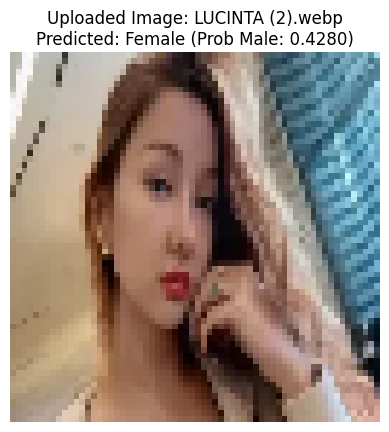

In [43]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Upload gambar
uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

    # Baca gambar dari file yang diunggah
    image_path = fn
    img = cv2.imread(image_path)

    if img is None:
        print(f"Error: Could not load image from {image_path}")
    else:
        # Preprocessing gambar: resize dan normalisasi (sesuai dengan preprocessing data training GoogLeNet)
        # Pastikan ukuran sesuai dengan input model GoogLeNet Anda (64x64)
        target_size = (64, 64) # Sesuaikan dengan ukuran input model GoogLeNet
        img_resized = cv2.resize(img, target_size)

        # Konversi BGR ke RGB (jika model dilatih dengan RGB)
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

        # Normalisasi piksel ke rentang [0, 1]
        img_normalized = img_rgb.astype('float32') / 255.0

        # Tambahkan dimensi batch (model expects input shape (batch_size, height, width, channels))
        img_input = np.expand_dims(img_normalized, axis=0)

        # Lakukan prediksi menggunakan model GoogLeNet yang sudah dilatih
        # Pastikan variabel 'googlenet_model' sudah ada dari sel sebelumnya
        if 'googlenet_model' in globals():
            prediction = googlenet_model.predict(img_input)

            # Ambil probabilitas kelas positif (Male)
            probability_male = prediction[0][0]

            # Tentukan kelas prediksi berdasarkan threshold (misal > 0.5 untuk Male)
            predicted_class = "Male" if probability_male > 0.5 else "Female"

            print(f"\nPrediction for {fn}:")
            print(f"Probability (Male): {probability_male:.4f}")
            print(f"Predicted class: {predicted_class}")

            # Tampilkan gambar yang diunggah
            plt.imshow(img_rgb)
            plt.title(f"Uploaded Image: {fn}\nPredicted: {predicted_class} (Prob Male: {probability_male:.4f})")
            plt.axis('off')
            plt.show()

        else:
            print("Error: GoogLeNet 'googlenet_model' not found. Please ensure the model building and training cells were executed.")

# ResNet (SKIP THIS)

## SETUP ENVIRONMENT & KAGGLE

In [ ]:
!pip install -q kaggle tensorflow keras numpy matplotlib scikit-learn

import os

# Upload kaggle.json (isi API Key kamu)
from google.colab import files
files.upload()  # <-- upload kaggle.json

# Buat folder kaggle & set permission
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jessicali9530/celeba-dataset

# Ekstrak dataset
!unzip -q celeba-dataset.zip -d celeba
print("✅ Dataset extracted successfully.")

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
 99% 1.31G/1.33G [00:10<00:00, 189MB/s]
100% 1.33G/1.33G [00:10<00:00, 141MB/s]
✅ Dataset extracted successfully.


## LOAD DATASET (CelebA)

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import cv2
from sklearn.model_selection import train_test_split

# Path ke data
img_dir = "/content/celeba/img_align_celeba/img_align_celeba"
attr_path = "/content/celeba/list_attr_celeba.csv"

# Load atribut (label)
attributes = pd.read_csv(attr_path)
male_labels = (attributes['Male'] == 1).astype(int)  # 1=Male, 0=Female

# Ambil sebagian data (misal 10k sample biar cepat)
sample_size = 10000
sample_data = attributes.sample(sample_size, random_state=42)
images = []
labels = []

for idx, row in sample_data.iterrows():
    img_path = os.path.join(img_dir, row['image_id'])
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    img = img / 255.0
    images.append(img)
    labels.append(1 if row['Male'] == 1 else 0)

images = np.array(images)
labels = np.array(labels)

train_images, val_images, train_labels, val_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

print("✅ Data loaded and split successfully.")
print(f"Train: {train_images.shape}, Val: {val_images.shape}")

✅ Data loaded and split successfully.
Train: (8000, 128, 128, 3), Val: (2000, 128, 128, 3)


## BUILD RESNET MODEL (GOOGLE COLAB CAN'T HANDLE)

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop

def build_resnet_model(learning_rate=0.001, dropout_rate=0.3, optimizer='adam'):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128,128,3))
    base_model.trainable = True  # <- samakan dengan VGG (fine-tune semua layer)

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(dropout_rate)(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)

    # optimizer selection
    opt = Adam(learning_rate=learning_rate) if optimizer == 'adam' else RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_resnet_model()
model.summary()

Model: "functional_2"

KeyboardInterrupt: 

## MODEL #2

In [ ]:
def build_resnet_model(learning_rate=0.001, dropout_rate=0.3):
    # Load ResNet50 tanpa top layer, pakai pretrained ImageNet
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128,128,3))
    base_model.trainable = False  # freeze semua layer base model → ringan

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(dropout_rate)(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)

    # Compile
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

## TRAINING (Hyperparameter Tuning Simple -> GOOGLE COLAB CANT HANDLE))

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Standard parameter (biar seimbang dengan AlexNet, GoogLeNet, dan VGG)
learning_rate = 0.001
dropout_rate = 0.3
optimizer = 'adam'
epochs = 10
# batch_size = 32
# batch_size = 16
batch_size = 8

model = build_resnet_model(
    learning_rate=learning_rate,
    dropout_rate=dropout_rate,
    optimizer=optimizer
)

# Callback early stopping biar training berhenti otomatis kalau val_accuracy stagnan
es = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)

print("🚀 Training ResNet model dimulai...")
history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=epochs,            # sama kayak VGG (10 epoch)
    batch_size=batch_size,    # batch size juga disamain
    callbacks=[es],
    verbose=1
)

print("✅ Training ResNet selesai.")

🚀 Training ResNet model dimulai...


## TRAINING #2

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

learning_rate = 0.001
dropout_rate = 0.3
epochs = 10
batch_size = 8  # kecil agar Colab Free nggak crash

model = build_resnet_model(learning_rate, dropout_rate)

# Early stopping biar training berhenti kalau val_accuracy stagnan
es = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)

print("🚀 Training ResNet model dimulai...")
history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[es],
    verbose=1
)
print("✅ Training ResNet selesai.")

🚀 Training ResNet model dimulai...


## EVALUATION

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluasi model pakai hasil training (bukan best_model tuning)
print("🔍 Evaluating ResNet model on validation set...")

val_preds = (model.predict(val_images) > 0.5).astype("int32")

# Laporan klasifikasi
print("\nClassification Report (ResNet):")
print(classification_report(val_labels, val_preds, target_names=['Female', 'Male']))

# Confusion matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Female','Male'], yticklabels=['Female','Male'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("ResNet Confusion Matrix")
plt.show()

# ResNet

## IMPORT LIBRARY

In [47]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import cv2
import os

## DATASET

In [57]:
img_dir = "/content/celeba_dataset_kaggle/50k" # Corrected image directory path
attr_path = "/content/list_attr_celeba.txt" # Corrected attribute file path

import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split

# Check if image directory exists and is not empty
if not os.path.exists(img_dir):
    print(f"Error: Image directory not found at {img_dir}")
    images = np.array([]) # Set images to empty array
    labels = np.array([]) # Set labels to empty array
else:
    image_files_in_dir = [f for f in os.listdir(img_dir) if f.endswith('.jpg') or f.endswith('.png')]
    if not image_files_in_dir:
        print(f"Error: No image files found in {img_dir}. Please check the extraction process.")
        images = np.array([]) # Set images to empty array
        labels = np.array([]) # Set labels to empty array
    else:
        print(f"Found {len(image_files_in_dir)} image files in {img_dir}")
        # Load atribut (label)
        try:
            # Skip the first row which contains the total number of images and use the first column as the index
            attributes = pd.read_csv(attr_path, skiprows=1, sep='\s+', index_col=0)
            male_labels_df = (attributes['Male'] == 1).astype(int) # Use a temporary variable for labels from df
            print(f"Attribute file loaded successfully from {attr_path}")

            # Ambil sample kecil untuk Colab Free
            sample_size = 2000  # lebih ringan
            # Use a fixed random state to ensure reproducibility of the sample
            # Ensure the sample is taken from attributes where image files exist
            available_image_ids = [os.path.basename(f) for f in image_files_in_dir]
            attributes_available = attributes[attributes.index.isin(available_image_ids)]

            if len(attributes_available) < sample_size:
                 print(f"Warning: Only {len(attributes_available)} image files with attribute data are available. Loading all of them.")
                 sample_data = attributes_available
            else:
                sample_data = attributes_available.sample(sample_size, random_state=42)

            images = []
            labels = []

            for idx, row in sample_data.iterrows():
                img_path = os.path.join(img_dir, idx) # Use the index (filename) to construct the path
                img = cv2.imread(img_path)
                # Check if image loaded successfully
                if img is not None:
                    img = cv2.resize(img, (128, 128))
                    img = img / 255.0
                    images.append(img)
                    labels.append(1 if row['Male'] == 1 else 0)
                else:
                    print(f"Warning: Could not load image {img_path}")

            images = np.array(images)
            labels = np.array(labels)

        except FileNotFoundError:
            print(f"Error: Attribute file not found at {attr_path}. Please ensure it's uploaded/extracted correctly.")
            images = np.array([]) # Set images to empty array
            labels = np.array([]) # Set labels to empty array
        except KeyError:
            print(f"Error: 'Male' column not found in the attribute file. Please check the file format.")
            images = np.array([]) # Set images to empty array
            labels = np.array([]) # Set labels to empty array
        except Exception as e:
            print(f"An unexpected error occurred during data loading: {e}")
            images = np.array([]) # Set images to empty array
            labels = np.array([]) # Set labels to empty array


# Only proceed with splitting if images were loaded
if len(images) > 0:
    train_images, val_images, train_labels, val_labels = train_test_split(
        images, labels, test_size=0.2, random_state=42, stratify=labels
    )

    print(f"✅ Data ready | Train: {train_images.shape}, Val: {val_labels.shape}") # Corrected shape printout
else:
    print("Data loading failed. train_images, val_images, train_labels, val_labels are not set.")
    train_images, val_images, train_labels, val_labels = None, None, None, None # Ensure variables are None

<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2284311237.py:26: SyntaxWarning: invalid escape sequence '\s'
  attributes = pd.read_csv(attr_path, skiprows=1, sep='\s+', index_col=0)


Found 50000 image files in /content/celeba_dataset_kaggle/50k
Attribute file loaded successfully from /content/list_attr_celeba.txt
✅ Data ready | Train: (1600, 128, 128, 3), Val: (400,)


## MODEL

In [58]:
def build_resnet_light(learning_rate=0.001, dropout_rate=0.2):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128,128,3))
    base_model.trainable = False  # freeze semua layer

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(dropout_rate)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_resnet_light()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## TRAINING

In [59]:
batch_size = 8   # kecil untuk Colab Free
epochs = 10

es = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)

print("🚀 Training Light ResNet model dimulai...")
history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[es],
    verbose=1
)
print("✅ Training selesai.")

🚀 Training Light ResNet model dimulai...
Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.5135 - loss: 0.7127 - val_accuracy: 0.5825 - val_loss: 0.6777
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5821 - loss: 0.6821 - val_accuracy: 0.5825 - val_loss: 0.6773
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5794 - loss: 0.6847 - val_accuracy: 0.5825 - val_loss: 0.6762
✅ Training selesai.


## EVALUATE

13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 419ms/step
📊 Classification Report:
              precision    recall  f1-score   support

      Female       0.58      1.00      0.74       233
        Male       0.00      0.00      0.00       167

    accuracy                           0.58       400
   macro avg       0.29      0.50      0.37       400
weighted avg       0.34      0.58      0.43       400



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


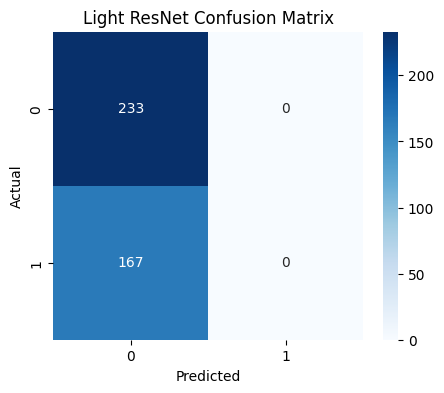

In [60]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Prediksi pada validation set
val_preds = (model.predict(val_images) > 0.5).astype("int32")

# Classification report
print("📊 Classification Report:")
print(classification_report(val_labels, val_preds, target_names=['Female', 'Male']))

# Confusion matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Light ResNet Confusion Matrix")
plt.show()

## Testing

Saving LUCINTA.webp to LUCINTA (3).webp
User uploaded file "LUCINTA (3).webp" with length 6030 bytes
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Prediction for LUCINTA (3).webp:
Probability (Male): 0.4222
Predicted class: Female


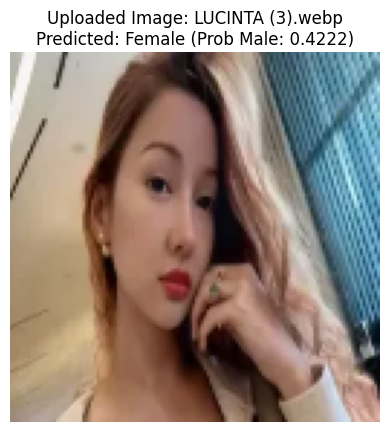

In [61]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Upload gambar
uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

    # Baca gambar dari file yang diunggah
    image_path = fn
    img = cv2.imread(image_path)

    if img is None:
        print(f"Error: Could not load image from {image_path}")
    else:
        # Preprocessing gambar: resize dan normalisasi (sesuai dengan preprocessing data training ResNet)
        # Pastikan ukuran sesuai dengan input model ResNet Anda (128x128)
        target_size = (128, 128) # Sesuaikan dengan ukuran input model ResNet
        img_resized = cv2.resize(img, target_size)

        # Konversi BGR ke RGB (jika model dilatih dengan RGB)
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

        # Normalisasi piksel ke rentang [0, 1]
        img_normalized = img_rgb.astype('float32') / 255.0

        # Tambahkan dimensi batch (model expects input shape (batch_size, height, width, channels))
        img_input = np.expand_dims(img_normalized, axis=0)

        # Lakukan prediksi menggunakan model ResNet yang sudah dilatih
        # Pastikan variabel 'model' (model ResNet) sudah ada dari sel sebelumnya
        if 'model' in globals():
            prediction = model.predict(img_input)

            # Ambil probabilitas kelas positif (Male)
            probability_male = prediction[0][0]

            # Tentukan kelas prediksi berdasarkan threshold (misal > 0.5 untuk Male)
            predicted_class = "Male" if probability_male > 0.5 else "Female"

            print(f"\nPrediction for {fn}:")
            print(f"Probability (Male): {probability_male:.4f}")
            print(f"Predicted class: {predicted_class}")

            # Tampilkan gambar yang diunggah
            plt.imshow(img_rgb)
            plt.title(f"Uploaded Image: {fn}\nPredicted: {predicted_class} (Prob Male: {probability_male:.4f})")
            plt.axis('off')
            plt.show()

        else:
            print("Error: ResNet 'model' not found. Please ensure the model building and training cells were executed.")

# AlexNet

## Import

In [62]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

## Reproducibility + config

In [63]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

INPUT_SHAPE = (128, 128, 3)
LEARNING_RATE = 1e-3
DROPOUT_RATE = 0.3
EPOCHS = 10
BATCH_SIZE = 32

## Safety checks for data

In [64]:
# Expect train_images, val_images, train_labels, val_labels to exist in notebook environment
if 'train_images' not in globals() or train_images is None:
    raise RuntimeError("train_images not found — run the data loading/splitting cells first.")
if 'val_images' not in globals() or val_images is None:
    raise RuntimeError("val_images not found — run the data loading/splitting cells first.")
if 'train_labels' not in globals() or train_labels is None:
    raise RuntimeError("train_labels not found — run the data loading/splitting cells first.")
if 'val_labels' not in globals() or val_labels is None:
    raise RuntimeError("val_labels not found — run the data loading/splitting cells first.")

# Ensure image dtype and scaling
if train_images.dtype != np.float32:
    train_images = train_images.astype('float32') / 255.0
    val_images = val_images.astype('float32') / 255.0

# Convert potential -1/1 labels to 0/1
unique_labels = np.unique(np.concatenate([train_labels.flatten(), val_labels.flatten()]))
if set(unique_labels.tolist()).issuperset({-1, 1}):
    train_labels = np.where(train_labels == -1, 0, 1)
    val_labels = np.where(val_labels == -1, 0, 1)

print("Data ready — shapes:")
print(" train_images:", train_images.shape, " val_images:", val_images.shape)
print(" train_labels unique:", np.unique(train_labels), " val_labels unique:", np.unique(val_labels))

Data ready — shapes:
 train_images: (1600, 128, 128, 3)  val_images: (400, 128, 128, 3)
 train_labels unique: [0 1]  val_labels unique: [0 1]


## Build AlexNet-like model

In [65]:
def build_alexnet(input_shape=INPUT_SHAPE, dropout_rate=DROPOUT_RATE, learning_rate=LEARNING_RATE):
    model = models.Sequential([
        # Conv1
        layers.Conv2D(96, (11,11), strides=(4,4), padding='same', activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),

        # Conv2
        layers.Conv2D(256, (5,5), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),

        # Conv3-5
        layers.Conv2D(384, (3,3), padding='same', activation='relu'),
        layers.Conv2D(384, (3,3), padding='same', activation='relu'),
        layers.Conv2D(256, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),

        # FC head
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(512, activation='relu'),
        layers.Dropout(dropout_rate),

        # Final output
        layers.Dense(1, activation='sigmoid')
    ])

    opt = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

alexnet = build_alexnet()
alexnet.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_57 (Conv2D)              │ (None, 32, 32, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 16, 16, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 16, 16, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 8, 8, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 8, 8, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 8, 8, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,109,441 (23.31 MB)

 Trainable params: 6,108,737 (23.30 MB)

 Non-trainable params: 704 (2.75 KB)

## Train

In [66]:
es = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)
print("Starting AlexNet training...")
history_alex = alexnet.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es],
    verbose=1
)
print("AlexNet training finished.")

Starting AlexNet training...
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.5433 - loss: 0.7038 - val_accuracy: 0.5825 - val_loss: 0.6858
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6428 - loss: 0.6373 - val_accuracy: 0.5825 - val_loss: 0.6865
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6622 - loss: 0.5941 - val_accuracy: 0.4175 - val_loss: 0.6940
AlexNet training finished.


## Evaluate & save results

Final Validation Loss: 0.6858
Final Validation Accuracy: 0.5825
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step

Classification Report (AlexNet):
              precision    recall  f1-score   support

      Female       0.58      1.00      0.74       233
        Male       0.00      0.00      0.00       167

    accuracy                           0.58       400
   macro avg       0.29      0.50      0.37       400
weighted avg       0.34      0.58      0.43       400



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


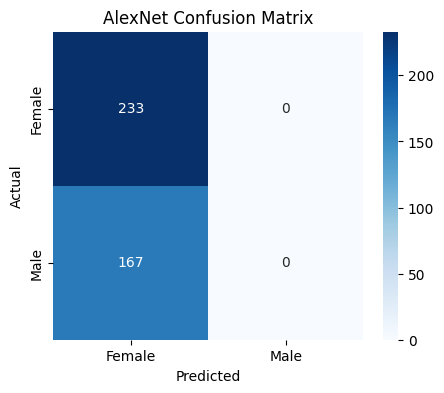

In [67]:
val_loss, val_acc = alexnet.evaluate(val_images, val_labels, verbose=0)
print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Final Validation Accuracy: {val_acc:.4f}")

# Classification report & confusion matrix
val_preds = (alexnet.predict(val_images) > 0.5).astype("int32")
print("\nClassification Report (AlexNet):")
print(classification_report(val_labels, val_preds, target_names=['Female','Male']))

cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Female','Male'], yticklabels=['Female','Male'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("AlexNet Confusion Matrix")
plt.show()

## Plot training history

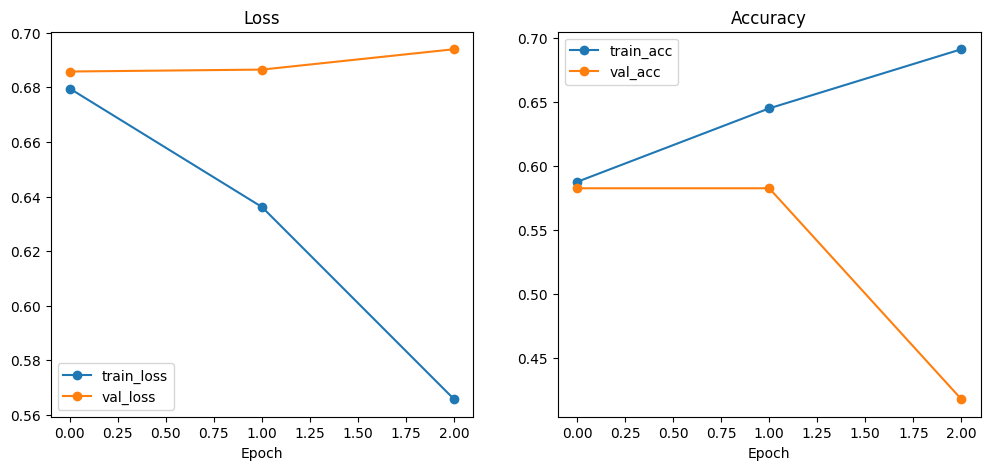

In [68]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_alex.history['loss'], marker='o', label='train_loss')
plt.plot(history_alex.history['val_loss'], marker='o', label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_alex.history['accuracy'], marker='o', label='train_acc')
plt.plot(history_alex.history['val_accuracy'], marker='o', label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Testing

Saving LUCINTA.webp to LUCINTA (4).webp
User uploaded file "LUCINTA (4).webp" with length 6030 bytes
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/step

Prediction for LUCINTA (4).webp:
Probability (Male): 0.4623
Predicted class: Female


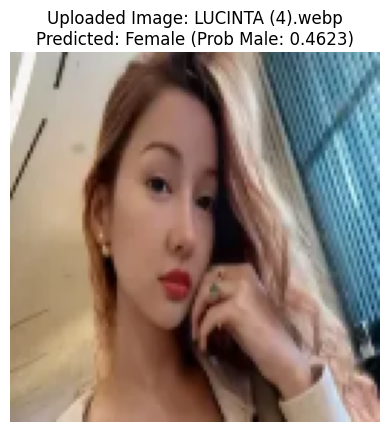

In [69]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Upload gambar
uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

    # Baca gambar dari file yang diunggah
    image_path = fn
    img = cv2.imread(image_path)

    if img is None:
        print(f"Error: Could not load image from {image_path}")
    else:
        # Preprocessing gambar: resize dan normalisasi (sesuai dengan preprocessing data training AlexNet)
        # Pastikan ukuran sesuai dengan input model AlexNet Anda (128x128)
        target_size = (128, 128) # Sesuaikan dengan ukuran input model AlexNet
        img_resized = cv2.resize(img, target_size)

        # Konversi BGR ke RGB (jika model dilatih dengan RGB)
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

        # Normalisasi piksel ke rentang [0, 1]
        img_normalized = img_rgb.astype('float32') / 255.0

        # Tambahkan dimensi batch (model expects input shape (batch_size, height, width, channels))
        img_input = np.expand_dims(img_normalized, axis=0)

        # Lakukan prediksi menggunakan model AlexNet yang sudah dilatih
        # Pastikan variabel 'alexnet' (model AlexNet) sudah ada dari sel sebelumnya
        if 'alexnet' in globals():
            prediction = alexnet.predict(img_input)

            # Ambil probabilitas kelas positif (Male)
            probability_male = prediction[0][0]

            # Tentukan kelas prediksi berdasarkan threshold (misal > 0.5 untuk Male)
            predicted_class = "Male" if probability_male > 0.5 else "Female"

            print(f"\nPrediction for {fn}:")
            print(f"Probability (Male): {probability_male:.4f}")
            print(f"Predicted class: {predicted_class}")

            # Tampilkan gambar yang diunggah
            plt.imshow(img_rgb)
            plt.title(f"Uploaded Image: {fn}\nPredicted: {predicted_class} (Prob Male: {probability_male:.4f})")
            plt.axis('off')
            plt.show()

        else:
            print("Error: AlexNet 'alexnet' not found. Please ensure the model building and training cells were executed.")